<center>
    <h1><b><font color="blue"> Notebook 3.1 - Outils pour améliorer les performances</font> </b></h1>
</center>

<b>Objectif du Notebook :</b>
<p>Étudier les performances d'un modèle de machine learning en fonction des différents traitements que l'on peut appliquer au jeu de données : traitement des valeurs manquantes, sélection de variables, rééchantillonnage. </p>

- <b>Le modèle choisi : Random Forest</b>
<p><i>Il présente l'avantage d'être rapide (avec les hyperparamètres de base) et performant (voir Notebook suivant)
Les conclusions peuvent toutefois être généraliser à d'autres modèles (non présentés ici).
Ce notebook n'a pas pour objectif d'optimiser les hyperparamètres, ce point sera étudié dans le Notebook suivant.</i></p>


- <b> Les différents traitements du jeu de données et méthodes testés : </b>
<p><i><ul>
- rééchantillonnage de la classe minoritaires
- vérification de l'absence de surapprentissage par validation croisée
- différents traitements des NaN
- sélection de variables
    </ul></i></p>

# Importation des librairies et fonctions Python

In [123]:
import time 
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold, RepeatedStratifiedKFold

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, recall_score, f1_score, precision_score, accuracy_score

from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from joblib import dump, load

<hr>
<h1> Chargement  et préparation des jeux de données </h1>
<hr>

L'un des objectifs de ce Notebook est de comparer les performances d'un algorithme de Random Forest sur un jeu de données dans lequel les valeurs manquantes ont été imputées (complétion par l'algorithme KNN-Imputer) avec ses performances sur un jeu de données dans lequel les valeurs manquantes ont été simplement supprimées.

Nous chargeons donc deux jeux de données issus de l'étape de preprocessing (voir NB1) :
- weatherAUS_nan : jeu de données complet avant imputation des valeurs manquantes 
- weatherAUS_imputer : jeu de données complet après imputation des valeurs manquantes 

## Chargement des deux jeux de données issus du preprocessing

In [2]:
# chargement et visualisation du jeu de données weatherAUS_nan
df_nan = pd.read_csv("weatherAUS_nan.csv").drop("Unnamed: 0", axis = 1)
print("weatherAUS_nan\n")
df_nan.info()
df_nan.head()

weatherAUS_nan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date                145460 non-null  object 
 1   Location            145460 non-null  object 
 2   MinTemp             143975 non-null  float64
 3   MaxTemp             144199 non-null  float64
 4   Rainfall            142199 non-null  float64
 5   Evaporation         82670 non-null   float64
 6   Sunshine            75625 non-null   float64
 7   WindGustSpeed       135197 non-null  float64
 8   WindSpeed9am        143693 non-null  float64
 9   WindSpeed3pm        142398 non-null  float64
 10  Humidity9am         142806 non-null  float64
 11  Humidity3pm         140953 non-null  float64
 12  Pressure9am         130395 non-null  float64
 13  Pressure3pm         130432 non-null  float64
 14  Cloud9am            89572 non-null   float64
 15  Cloud3pm          

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,Rain_J-2,Rain_J+2,Rain_J+3,Mois_sin,Mois_cos,clim_méditerranéen,clim_océanique,clim_sec,clim_subtropical,clim_tropical
0,2008-07-01,Adelaide,8.8,15.7,5.0,1.6,2.6,48.0,13.0,15.0,...,NaN,0.0,0.0,1.224647e-16,-1.0,1,0,0,0,0
1,2008-07-02,Adelaide,12.7,15.8,0.8,1.4,7.8,35.0,13.0,15.0,...,NaN,0.0,0.0,1.224647e-16,-1.0,1,0,0,0,0
2,2008-07-03,Adelaide,6.2,15.1,0.0,1.8,2.1,20.0,2.0,11.0,...,1.0,0.0,0.0,1.224647e-16,-1.0,1,0,0,0,0
3,2008-07-04,Adelaide,5.3,15.9,0.0,1.4,8.0,30.0,6.0,13.0,...,0.0,0.0,1.0,1.224647e-16,-1.0,1,0,0,0,0
4,2008-07-05,Adelaide,9.8,15.4,0.0,NaN,0.9,30.0,9.0,9.0,...,0.0,1.0,1.0,1.224647e-16,-1.0,1,0,0,0,0


In [3]:
# chargement et visualisation du jeu de données weatherAUS_imputer
df_imp = pd.read_csv("weatherAUS_imputer.csv").drop("Unnamed: 0", axis = 1)
print("weatherAUS_imputer\n")
df_imp.info()
df_imp.head()

weatherAUS_imputer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145455 entries, 0 to 145454
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   MinTemp             145455 non-null  float64
 1   MaxTemp             145455 non-null  float64
 2   Rainfall            145455 non-null  float64
 3   Evaporation         145455 non-null  float64
 4   Sunshine            145455 non-null  float64
 5   WindGustSpeed       145455 non-null  float64
 6   WindSpeed9am        145455 non-null  float64
 7   WindSpeed3pm        145455 non-null  float64
 8   Humidity9am         145455 non-null  float64
 9   Humidity3pm         145455 non-null  float64
 10  Pressure9am         145455 non-null  float64
 11  Pressure3pm         145455 non-null  float64
 12  Cloud9am            145455 non-null  int64  
 13  Cloud3pm            145455 non-null  int64  
 14  Temp9am             145455 non-null  float64
 15  Temp3pm       

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Mois_sin,Mois_cos,clim_méditerranéen,clim_océanique,clim_sec,clim_subtropical,clim_tropical,Date,Location,Climat_Koppen
0,6.2,15.1,0.0,1.80,2.1,20.0,2.0,11.0,81.0,56.0,...,-0.281733,-0.959493,1,0,0,0,0,2008-07-03,Adelaide,Csa
1,5.3,15.9,0.0,1.40,8.0,30.0,6.0,13.0,71.0,46.0,...,-0.281733,-0.959493,1,0,0,0,0,2008-07-04,Adelaide,Csa
2,9.8,15.4,0.0,2.24,0.9,30.0,9.0,9.0,56.0,67.0,...,-0.281733,-0.959493,1,0,0,0,0,2008-07-05,Adelaide,Csa
3,11.3,15.7,8.1,3.32,1.5,52.0,15.0,22.0,62.0,62.0,...,-0.281733,-0.959493,1,0,0,0,0,2008-07-06,Adelaide,Csa
4,7.6,11.2,16.2,4.60,1.1,46.0,17.0,13.0,83.0,88.0,...,-0.281733,-0.959493,1,0,0,0,0,2008-07-07,Adelaide,Csa


## Suppression des valeurs manquantes de weatherAUS_nan

### 1e méthode : suppression simple par la méthode dropna

In [4]:
# suppression des valeurs manquantes et visualisation du jeu de données dropna
df_dropna = df_nan.dropna()
df_dropna.info()
print("\nTaille du jeu de données dropna =", round(len(df_dropna) / len(df_nan)*100, 0), "% du jeu de données complet.")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56564 entries, 9273 to 145431
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                56564 non-null  object 
 1   Location            56564 non-null  object 
 2   MinTemp             56564 non-null  float64
 3   MaxTemp             56564 non-null  float64
 4   Rainfall            56564 non-null  float64
 5   Evaporation         56564 non-null  float64
 6   Sunshine            56564 non-null  float64
 7   WindGustSpeed       56564 non-null  float64
 8   WindSpeed9am        56564 non-null  float64
 9   WindSpeed3pm        56564 non-null  float64
 10  Humidity9am         56564 non-null  float64
 11  Humidity3pm         56564 non-null  float64
 12  Pressure9am         56564 non-null  float64
 13  Pressure3pm         56564 non-null  float64
 14  Cloud9am            56564 non-null  float64
 15  Cloud3pm            56564 non-null  float64
 16  

La taille du jeu de données a été considérablement réduite par la suppression de l'ensemble des observations contenant des NaN. Cette réduction pourrait avoir des conséquences (positives ou négatives) sur les performances de nos algorithmes, que ce soit en terme de résultats ou de temps de calcul.

### 2e méthode : suppression des variables contenant la majorité des valeurs manquantes

Répartition des NaN au sein des 15 variables en contenant le plus :
Wind3pm_Ang       1.092597
Humidity3pm       1.164696
WindGustSpeed     2.652157
WindGust_cos      2.668438
WindGust_Ang      2.668438
WindGust_sin      2.668438
Wind9am_sin       2.730458
Wind9am_cos       2.730458
Wind9am_Ang       2.730458
Pressure3pm       3.883525
Pressure9am       3.893087
Cloud9am         14.442538
Cloud3pm         15.339253
Evaporation      16.226148
Sunshine         18.046712
dtype: float64


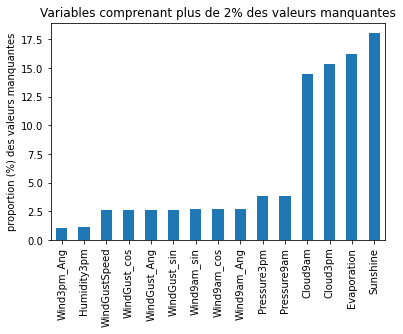

In [5]:
# Répartiton des NaN par colonne 
nan = (df_nan.isna().sum(axis=0) / df_nan.isna().sum(axis=0).sum()).sort_values()
nanmax = nan.tail(15)*100
print("Répartition des NaN au sein des 15 variables en contenant le plus :")
print(nanmax)

# Visualisation des variables contenant le plus de NaN
nanmax.plot(x=nanmax.index, y=nanmax.values, kind='bar')
plt.title("Variables comprenant plus de 2% des valeurs manquantes")
plt.ylabel("proportion (%) des valeurs manquantes");

Les variables Cloud9am, Cloud3pm, Evaporation et Sunshine regroupent à elles seules plus de 63 % des valeurs manquantes.

Nous créons donc un jeu de données dropvar qui ne contient pas ces variables. Les NaN restantes sont supprimées par la méthode dropna.

In [6]:
# suppression des valeurs manquantes et visualisation du jeu de données dropvar
df_dropvar = df_nan.drop(['Cloud9am', 'Cloud3pm', 'Evaporation', 'Sunshine'], axis = 1).dropna()
df_dropvar.info()
print("\nTaille du jeu de données dropvar =", round(len(df_dropvar) / len(df_nan)*100, 0), "% du jeu de données complet.")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113675 entries, 2 to 145456
Data columns (total 42 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date                113675 non-null  object 
 1   Location            113675 non-null  object 
 2   MinTemp             113675 non-null  float64
 3   MaxTemp             113675 non-null  float64
 4   Rainfall            113675 non-null  float64
 5   WindGustSpeed       113675 non-null  float64
 6   WindSpeed9am        113675 non-null  float64
 7   WindSpeed3pm        113675 non-null  float64
 8   Humidity9am         113675 non-null  float64
 9   Humidity3pm         113675 non-null  float64
 10  Pressure9am         113675 non-null  float64
 11  Pressure3pm         113675 non-null  float64
 12  Temp9am             113675 non-null  float64
 13  Temp3pm             113675 non-null  float64
 14  RainToday_Num       113675 non-null  int64  
 15  RainTomorrow_Num    113675 non-nul

La taille du jeu de données reste cette fois importante. Toutefois, la suppression de certaines variables pourrait avoir un impact sur les performances du modèle.

## Sélection des variables servant à entrainer le modèle

In [7]:
#sélection des variables explicatives
features = ["RainToday_Num", "Rain_J-1", "Rain_J-2", "MinTemp", "MaxTemp", "Sunshine", "Evaporation",
            "Humidity3pm", "Humidity9am", "Pressure9am", "Pressure3pm", "Cloud3pm", "Cloud9am", 
            "Wind9am_cos", "Wind3pm_cos", "WindGust_cos", "Wind9am_sin", "Wind3pm_sin", "WindGust_sin", 
           "clim_océanique", "clim_méditerranéen", "clim_sec", "clim_tropical", "clim_subtropical",
            "Mois_sin", "Mois_cos"
           ]

features_dropvar = ["RainToday_Num", "Rain_J-1", "Rain_J-2", "MinTemp", "MaxTemp", "Humidity3pm", 
                    "Humidity9am", "Pressure9am", "Pressure3pm", "Wind9am_cos", "Wind3pm_cos", 
                    "WindGust_cos", "Wind9am_sin", "Wind3pm_sin", "WindGust_sin", 
                    "clim_océanique", "clim_méditerranéen", "clim_sec", "clim_tropical", "clim_subtropical", 
                    "Mois_sin", "Mois_cos"
                   ]

#séparation features / target
X_imp = df_imp[features]
y_imp = df_imp["RainTomorrow_Num"]

X_dropna = df_dropna[features]
y_dropna = df_dropna["RainTomorrow_Num"]

X_dropvar = df_dropvar[features_dropvar]
y_dropvar = df_dropvar["RainTomorrow_Num"]

<hr>
<h1> Modèle de référence </h1>
<hr>

Le modèle entrainé ci-dessous nous servira de base pour comparer les performances en fonction des différents traitements appliqués aux jeu de donnée.

Nous avons choisi un modèle de Random Forest qui a l'avantage d'être rapide tout en proposant des performances intéressantes (voir Notebook 3.2). Le modèle sera entrainé sur le jeu de données le plus complet : X_imp.

Remarque : Nous ne cherchons pas ici à optimiser le modèle en évaluant les meilleurs hyperparamètres. Ce point sera abordé dans le notebook 3.2.

## Entrainement et évaluation

In [8]:
# séparation des données en jeu d'entrainement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.2, random_state=0)

In [40]:
%%time
# création et entrainement du modèle
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# prédictions
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

# évaluation du modèle
print("Performances sur train \n", classification_report(y_train, y_pred_train))
print("----------------------------------------------------------------------")
print("Performances sur test \n", classification_report(y_test, y_pred))

Performances sur train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     90832
           1       1.00      1.00      1.00     25532

    accuracy                           1.00    116364
   macro avg       1.00      1.00      1.00    116364
weighted avg       1.00      1.00      1.00    116364

----------------------------------------------------------------------
Performances sur test 
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     22746
           1       0.76      0.49      0.60      6345

    accuracy                           0.86     29091
   macro avg       0.82      0.72      0.75     29091
weighted avg       0.85      0.86      0.84     29091

Wall time: 32.7 s


## Interprétation

,Précision,Rappel,F1-score
0,0.87,0.96,0.91
1,0.76,0.49,0.60


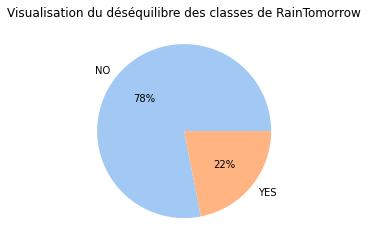

In [41]:
# visualisation du déséquilibre des classes
x = df_imp.RainTomorrow_Num.value_counts(normalize=True)

colors = sns.color_palette('pastel')[0:5]
labels = ['NO', 'YES']
plt.pie(x, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Visualisation du déséquilibre des classes de RainTomorrow");

# résumé des performances
prec0 = round(precision_score(y_test, y_pred, pos_label=0), 2)
prec1 = round(precision_score(y_test, y_pred), 2)
rec0 = round(recall_score(y_test, y_pred, pos_label=0), 2)
rec1 = round(recall_score(y_test, y_pred), 2)
f1sc0 = round(f1_score(y_test, y_pred, pos_label=0), 2)
f1sc1 = round(f1_score(y_test, y_pred), 2)
dfsc = pd.DataFrame({
    "Précision": [prec0, prec1],
    "Rappel": [rec0, rec1],
    "F1-score": [f1sc0, f1sc1]})
dfsc

On constate que les métriques sont bien meilleures sur la classe majoritaire 0 que sur la classe minoritaire 1.
Le déséquilibre entre les deux classes est une cause très probable à cette différence de performance.

Nous allons donc rééquilibrer notre échantillon dans le but d’améliorer la détection de la classe 1.
Deux possibilités :
- Sous-échantillonnage de la classe 0 (RandomUnderSampler)
- Sur-échantillonnage de la classe 1 (RandomOverSampler)

<hr>
<h1> Méthodes de rééquilibrage des classes </h1>
<hr>

## Rééchantillonnage par des algorithmes de la librairie imblearn

In [26]:
%%time
#Sous-échantillonnage par RandomUnderSampler
rus = RandomUnderSampler()
X_ru, y_ru = rus.fit_resample(X_train, y_train)

#Sur-échantillonnage par RandomOverSampler
ros = RandomOverSampler()
X_ro, y_ro = ros.fit_resample(X_train, y_train)

Wall time: 726 ms


## Entrainement d'une RandomForest sur le jeu de données sous-échantillonné


In [42]:
%%time
# création et entrainement du modèle
rfru = RandomForestClassifier()
rfru.fit(X_ru, y_ru)

# prédictions
y_pred = rfru.predict(X_test)
y_pred_train = rfru.predict(X_ru)

Wall time: 13.5 s


In [43]:
# affichage des performances
print("Performances sur train : accuracy = ", round(accuracy_score(y_ru, y_pred_train), 3))
print(classification_report_imbalanced(y_ru, y_pred_train))
print("----------------------------------------------------------------------")
print("Performances sur test : accuracy = ", round(accuracy_score(y_test, y_pred), 3))
print(classification_report_imbalanced(y_test, y_pred))

Performances sur train : accuracy =  1.0
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00     25532
          1       1.00      1.00      1.00      1.00      1.00      1.00     25532

avg / total       1.00      1.00      1.00      1.00      1.00      1.00     51064

----------------------------------------------------------------------
Performances sur test : accuracy =  0.799
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.80      0.79      0.86      0.79      0.63     22746
          1       0.53      0.79      0.80      0.63      0.79      0.63      6345

avg / total       0.84      0.80      0.79      0.81      0.79      0.63     29091



## Comparaison des performances avec le modèle de référence

In [49]:
# résumé des performances
prec0 = round(precision_score(y_test, y_pred, pos_label=0), 2)
prec1 = round(precision_score(y_test, y_pred), 2)
rec0 = round(recall_score(y_test, y_pred, pos_label=0), 2)
rec1 = round(recall_score(y_test, y_pred), 2)
f1sc0 = round(f1_score(y_test, y_pred, pos_label=0), 2)
f1sc1 = round(f1_score(y_test, y_pred), 2)
dfsc_ru = pd.DataFrame({
    "Précision": [prec0, prec1],
    "Rappel": [rec0, rec1],
    "F1-score": [f1sc0, f1sc1]})

print("Avant sous-échantillonnage :")
print(dfsc)

print("\nAprès sous-échantillonnage :")
print(dfsc_ru)

Avant sous-échantillonnage :
   Précision  Rappel  F1-score
0       0.87    0.96      0.91
1       0.76    0.49      0.60

Après sous-échantillonnage :
   Précision  Rappel  F1-score
0       0.93    0.80      0.86
1       0.53    0.79      0.63


Observations :

Pour la classe 1, on constate que le score F1 est légèrement meilleur après rééquilibrage, en raison d’un score de rappel beaucoup plus élevé, proche de celui de la classe 0. Toutefois, ce gain significatif de rappel s'accompagne d'une perte de précision.
Le rééchantillonnage a donc permis un gain significatif de rappel, au détriment toutefois de la précision. 

## Complément : Entrainement d'une RandomForest sur le jeu de données sur-échantillonné

In [51]:
%%time
# création et entrainement du modèle
rfro = RandomForestClassifier()
rfro.fit(X_ro, y_ro)

# prédictions
y_pred = rfro.predict(X_test)
y_pred_train = rfro.predict(X_ro)

Wall time: 54.5 s


In [52]:
# affichage des performances
print("Performances sur train : accuracy = ", round(accuracy_score(y_ro, y_pred_train), 3))
print(classification_report_imbalanced(y_ro, y_pred_train))
print("----------------------------------------------------------------------")
print("Performances sur test : accuracy = ", round(accuracy_score(y_test, y_pred), 3))
print(classification_report_imbalanced(y_test, y_pred))

Performances sur train : accuracy =  1.0
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00     90832
          1       1.00      1.00      1.00      1.00      1.00      1.00     90832

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    181664

----------------------------------------------------------------------
Performances sur test : accuracy =  0.857
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.94      0.57      0.91      0.73      0.55     22746
          1       0.72      0.57      0.94      0.63      0.73      0.51      6345

avg / total       0.85      0.86      0.65      0.85      0.73      0.54     29091



Observations :
L'accuracy est meilleure qu'avec un sous-échantillonnage, mais le F1-score sur la classe 1 est proche.
Les valeurs de précision et de rappel sont intermédiaire entre le modèle de référence et le modèle après sous-échantillonnage.

Remarque : D'autres algorithmes du package imblearn ont été testé. Souvent long à entrainer, ils n'offrent pas de résultats intéressants et ne seront pas présentés dans ce Notebook.

## Conclusion

Le sous-échantillonnage de la classe 0 permet une augmentation significative du rappel au détriment d'une baisse de la précision.

Dans les sections suivantes, nous présenterons les techniques mises en œuvre pour rechercher les causes du faible score de précision après sous-échantillonnage et tenter de l’améliorer.

Quelles sont les causes du problème ? Quatre hypothèses seront testées :
-	le surapprentissage.
-	les seuils de probabilités de détection de la classe 1.
-	le traitement des valeurs manquantes.
-	certaines variables nuisent à l'entrainement du modèle.

<hr>
<h1>Validation croisée pour détecter un problème de surapprentissage</h1>
<hr>

Hypothèse : La chute de précision entre le train et le test est due à un problème de surapprentissage.

Méthode utilisée : cross_val_score avec un StratifiedKFold comprenant 10 sous-échantillons mélangées du jeu de données rééquilibré.

À chaque itération, le modèle est entrainé et évalué sur des portions différentes du jeu de données.
L'utilisation de Stratified KFold permet de garantir un équilibre entre les classes au sein des différents échantillons.

In [55]:
%%time
# Création d'un objet StratifieKFold et validation croisée
skf = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(RandomForestClassifier(), X_ru, y_ru, scoring="precision", cv=skf, n_jobs=-1)

# Affichage des scores
print("Jeu de données rééquilibré :")
print("Scores de précision: ", np.round(scores, 2))
print("Score moyen : ", np.round(np.mean(scores), 2))
print("Ecart-type :", np.round(np.std(scores), 2))

Jeu de données rééquilibré :
Scores de précision:  [0.8  0.79 0.8  0.79 0.79 0.8  0.79 0.8  0.79 0.79]
Score moyen :  0.79
Ecart-type : 0.01
Wall time: 48 s


<b>Observations</b> : Les scores obtenus sur les différents échantillons aléatoires sont très proches et élevés. La validation croisée ne permet donc pas de mettre en évidence un problème de surapprentissage.
Comment expliquer alors la chute de précision entre train et test après rééquilibrage ?

<b>Interprétation de la différence entre précision et rappel après rééquilibrage :</b> 
<p>La différence de performance entre train et test est inhérente au rééquilibrage des classes qui ne se fait que sur le jeu de données train. Or, sur le jeu de données test, la classe 1 est sous-représentée. </p>

Ainsi, le jeu de test contient plus d'objets de la classe 0 que le jeu de données train, dont une partie sera nécessairement mal classée par le modèle (faux positifs).
Le taux de faux-positif sera donc plus élevé sur test que sur train, ce qui entrainera une chute de précision.

En revanche, le jeu de test contient moins d'objets de la classe 1 que le jeu de données train. Ainsi, même si certains d'entre eux sont mal détectés (faux négatifs), ils sont peu nombreux et le taux de faux négatif restera donc faible. 

Rappelons les formules de calcul de la précision et du rappel : 

<p><i>Précision = Nombre de vrais positifs / Nombre de prédictions positives = VP / (VP + FP)</i></p>
<p><i>Rappel = Nombre de vrais positifs / Nombre d'observations réellement positives = VP / (VP + FN)</i></p>
<p><i>Avec VP : Vrais positifs, FP : Faux positifs, FN : Faux négatifs</i></p>


On voit bien que le nombre de faux positifs (FP) n'entre pas dans le calcul du rappel. Celui-ci est donc moins sensible au déséquilibre de classe que la précision.

Nous allons vérifier ces interprétations en évaluant le modèle sur un jeu de données test préalablement rééquilibré. 


In [57]:
#rééchantillonnage du test
rus2 = RandomUnderSampler()
X_test_ru, y_test_ru = rus2.fit_resample(X_test, y_test)

#prédictions et évaluation
y_pred_test_ru = rfru.predict(X_test_ru)
print("performances sur test rééchantillonné \n", classification_report_imbalanced(y_test_ru, y_pred_test_ru))

performances sur test rééchantillonné 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.79      0.80      0.79      0.80      0.80      0.63      6345
          1       0.80      0.79      0.80      0.79      0.80      0.63      6345

avg / total       0.80      0.80      0.80      0.80      0.80      0.63     12690



Conclusion :
On obtient cette fois de bonnes performances, proche du jeu de données train.
Le modèle est donc plutôt performant sur un jeu de données test rééchantillonné, ce qui confirme que nous n'avons pas affaire à un problème de surapprentissage.

Toutefois, gardons en tête que cette technique de rééchantillonnage n'est pas applicable dans la réalité pour les futures prédictions de notre modèle, ces données étant par définition non étiquetées donc non rééquilibrables. La technique de rééchantillonnage ne peut servir qu'à entrainer le modèle.
Or, nous aurons probablement affaire à des données déséquilibrées, le déséquilibre de classe étant général (pour tous les climats et toutes les années).

Notre problème de précision persiste donc.

Dans la section suivante, nous allons comparer de façon plus détaillée les scores avec et sans rééquilibrage en modifiant le seuil de probabilité pour la détection de la classe 1.

<hr>
<h1>Comparaison des performances en modifiant le seuils de probabilité pour la détection de la classe 1</h1>
<hr>

Hypothèse : Les scores dépendent fortement du seuil de probabilité choisi.

La principale métrique utilisée pour comparer les performances sera le score F1. Il a l'avantage de combiner les scores de précision et de rappel. Les scores présentés sont ceux de la classe 1.

## Jeu de données déséquilibré

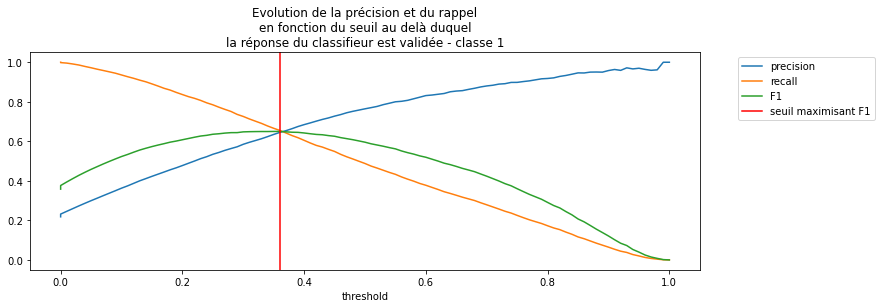

In [76]:
# Prédiction des probabilités d'appartenance à la classe 1
y_probs = rf.predict_proba(X_test)

# Graphique de l'évolution des scores des métriques en fonction du seuil de décision
precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:, 1], pos_label=1)

dfpr0 = pd.DataFrame(dict(precision=precision, recall=recall, threshold=[0] + list(thresholds)))
dfpr0['F1']= 2 * (dfpr0.precision * dfpr0.recall) / (dfpr0.precision + dfpr0.recall)
dfpr0max = dfpr0[dfpr0.F1 == dfpr0.F1.max()]

dfpr0.plot(x="threshold", y=['precision', 'recall', 'F1'], figsize=(12, 4))
plt.title("Evolution de la précision et du rappel\nen fonction du seuil au delà duquel\n" +
             "la réponse du classifieur est validée - classe 1")
plt.axvline(x=dfpr0[dfpr0.F1 == dfpr0.F1.max()].threshold.values[0], color='red', label="seuil maximisant F1")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [59]:
print("seuil de décision maximisant le score F1 :")
dfpr[dfpr.F1 == dfpr.F1.max()]

seuil de décision maximisant le score F1 :


,precision,recall,threshold,F1
37,0.644996,0.655162,0.36,0.650039


## Jeu de données rééquilibré

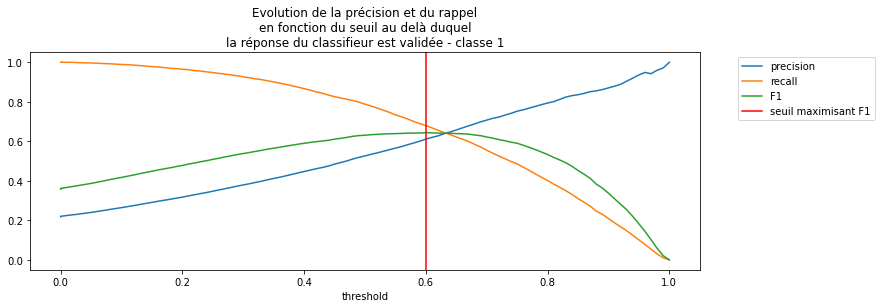

In [75]:
# Prédiction des probabilités d'appartenance à la classe 1
y_probs = rfru.predict_proba(X_test)

# Graphique de l'évolution des scores des métriques en fonction du seuil de décision
precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:, 1], pos_label=1)

dfpr1 = pd.DataFrame(dict(precision=precision, recall=recall, threshold=[0] + list(thresholds)))
dfpr1['F1']= 2 * (dfpr1.precision * dfpr1.recall) / (dfpr1.precision + dfpr1.recall)
dfpr1max = dfpr1[dfpr1.F1 == dfpr1.F1.max()]

dfpr1.plot(x="threshold", y=['precision', 'recall', 'F1'], figsize=(12, 4))
plt.title("Evolution de la précision et du rappel\nen fonction du seuil au delà duquel\n" +
             "la réponse du classifieur est validée - classe 1")
plt.axvline(x=dfpr1[dfpr1.F1 == dfpr1.F1.max()].threshold.values[0], color='red', label="seuil maximisant F1")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [74]:
print("seuil de décision maximisant le score F1 :")
dfpr = pd.concat([dfpr0max, dfpr1max])
dfpr.index = ["avant équilibrage", "après équilibrage"]
dfpr

seuil de décision maximisant le score F1 :


,precision,recall,threshold,F1
avant équilibrage,0.644996,0.655162,0.36,0.650039
après équilibrage,0.611080,0.679748,0.60,0.643587


Observations :
En choisissant un seuil de probabilité maximisant F1, on constate que les deux modèles ont des performances très proches pour les trois métriques (précision, rappel et score F1). 

La différence majeure entre les deux modèles est le seuil de probabilité permettant d'obtenir le meilleur score F1 (0.60 avec rééquilibrage contre 0.36 sans rééquilibrage). 
Sans rééchantillonnage, il est donc nécessaire de baisser fortement le seuil de probabilité pour détecter correctement la classe 1, alors qu'avec rééchantillonnage, on obtient directement un score F1 plus proche du maximum et un bon score de rappel avec la méthode predict simple (seuil de 50%).

Conclusion :
Cette étude montre que le rééchantillonnage ne permet pas d'améliorer réellement les performances du modèle.
La technique de rééchantillonnage permet toutefois d'améliorer le F1-score pour un seuil de probabilité standard fixé à 0,5. Pour ce seuil, la détection de la classe 1 sera meilleure. Ce gain se fait cependant au détriment d'une perte de précision.

Cette technique est donc pertinente si l'on cherche à détecter un maximum de jours pluvieux, au risque d'avoir des faux positifs. 

Elle permet également d'entrainer plusieurs modèles sans trop se soucier du seuil de probabilité qui peut rester fixé à 0.5.
Pour cette raison, nous appliquerons un rééchantillonnage du jeu de données train pour tous les modèles que nous testerons. 


<hr>
<h1>Comparaison des performances pour différents traitements des valeurs manquantes</h1>
<hr>

Hypothèse : Les performances dépendent de la méthode de traitement des valeurs manquantes.

Nous allons testé le modèle sur les jeux de données dans lequels les valeurs manquantes ont été supprimées. Ces jeux de données subiront un rééquilibrage préliminaire.

# Jeu de données dropna (suppression de toutes les observations avec NaN)

In [79]:
# séparation du jeu de données en ensembles d'entrainement et de test
X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(X_dropna, y_dropna, test_size=0.2)

#Sous-échantillonnage par RandomUnderSampler
rus = RandomUnderSampler()
X_ru_na, y_ru_na = rus.fit_resample(X_train_na, y_train_na)

In [80]:
%%time
#création et entrainement d'une Random Forest sur le jeu de données dropna
rf_na = RandomForestClassifier()
rf_na.fit(X_ru_na, y_ru_na)

#prédictions
y_pred = rf_na.predict(X_test_na)
y_pred_train = rf_na.predict(X_ru_na)

# évaluation du modèle
print("Performances sur train \n", classification_report(y_ru_na, y_pred_train))
print("----------------------------------------------------------------------")
print("Performances sur test \n", classification_report(y_test_na, y_pred))

Performances sur train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9951
           1       1.00      1.00      1.00      9951

    accuracy                           1.00     19902
   macro avg       1.00      1.00      1.00     19902
weighted avg       1.00      1.00      1.00     19902

----------------------------------------------------------------------
Performances sur test 
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      8837
           1       0.55      0.83      0.66      2476

    accuracy                           0.81     11313
   macro avg       0.75      0.82      0.77     11313
weighted avg       0.86      0.81      0.83     11313

Wall time: 5.4 s


# Jeu de données dropvar (suppression des variables présentant beaucoup de NaN)

In [81]:
# séparation du jeu de données en ensembles d'entrainement et de test
X_train_var, X_test_var, y_train_var, y_test_var = train_test_split(X_dropvar, y_dropvar, test_size=0.2)

#Sous-échantillonnage par RandomUnderSampler
rus = RandomUnderSampler()
X_ru_var, y_ru_var = rus.fit_resample(X_train_var, y_train_var)

In [82]:
%%time
#création et entrainement d'une Random Forest sur le jeu de données dropna
rf_var = RandomForestClassifier()
rf_var.fit(X_ru_var, y_ru_var)

#prédictions
y_pred = rf_var.predict(X_test_var)
y_pred_train = rf_var.predict(X_ru_var)

# évaluation du modèle
print("Performances sur train \n", classification_report(y_ru_var, y_pred_train))
print("----------------------------------------------------------------------")
print("Performances sur test \n", classification_report(y_test_var, y_pred))

Performances sur train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20055
           1       1.00      1.00      1.00     20055

    accuracy                           1.00     40110
   macro avg       1.00      1.00      1.00     40110
weighted avg       1.00      1.00      1.00     40110

----------------------------------------------------------------------
Performances sur test 
               precision    recall  f1-score   support

           0       0.93      0.81      0.87     17771
           1       0.53      0.79      0.64      4964

    accuracy                           0.80     22735
   macro avg       0.73      0.80      0.75     22735
weighted avg       0.85      0.80      0.82     22735

Wall time: 8.59 s


## Visualisation de l'évolution des métriques en fonction du seuil de décision pour le meilleur modèle (dropna)

seuil maximisant F1 :


,precision,recall,threshold,F1
58,0.612583,0.747173,0.58,0.673217


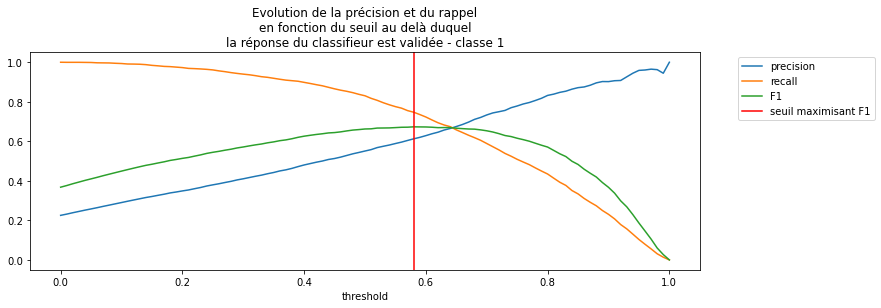

In [106]:
# Prédiction des probabilités d'appartenance à la classe 1
y_probs = rf_na.predict_proba(X_test_na)

# Graphique de l'évolution des scores des métriques en fonction du seuil de décision
precision, recall, thresholds = precision_recall_curve(y_test_na, y_probs[:, 1], pos_label=1)

dfpr = pd.DataFrame(dict(precision=precision, recall=recall, threshold=[0] + list(thresholds)))
dfpr['F1']= 2 * (dfpr.precision * dfpr.recall) / (dfpr.precision + dfpr.recall)
dfprmax = dfpr[dfpr.F1 == dfpr.F1.max()]

dfpr.plot(x="threshold", y=['precision', 'recall', 'F1'], figsize=(12, 4))
plt.title("Evolution de la précision et du rappel\nen fonction du seuil au delà duquel\n" +
             "la réponse du classifieur est validée - classe 1")
plt.axvline(x=dfpr[dfpr.F1 == dfpr.F1.max()].threshold.values[0], color='red', label="seuil maximisant F1")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

print("seuil maximisant F1 :")
dfprmax

## Conclusions

Les performances du modèle sont meilleures sur les jeux de données dropna et dropvar que sur le jeu de données imputer.
Le jeu de données dropna présentent les meilleures performances, en plus d'être le plus rapide.

L'interpolation des valeurs manquantes a donc un impact négatif sur les performances du modèle. Le modèle est plus performant s'il est entrainé exclusivement sur des données réelles.
Les différences sensibles de performance entre dropna et dropvar suggère qu'au moins une partie des variables supprimées de dropvar (Cloud9am, Cloud3pm, Evaporation, Sunshine) ont de l'importance pour l'entrainement du modèle.

Nous utiliserons donc préférentiellement le jeu de données dropna pour entrainer nos algorithmes. En plus d'un gain probable de performances, les temps de calcul seront significativement réduits, notamment pour la recherche des meilleurs hyperparamètres.

Dans la section suivante, nous chercherons à sélectionner les meilleures variables pour l'entrainement.

<hr>
<h1>Sélection de variables</h1>
<hr>

Hypothèse : Des variables peu pertinentes perturbent le modèle, ce qui affecte ses performances.

##  1e technique : suppression de variables corrélées entre elles

Cette technique s'appuie sur les corrélations entre les variables du jeu de données.
Nous travaillerons ici sur le jeu de données dropna.

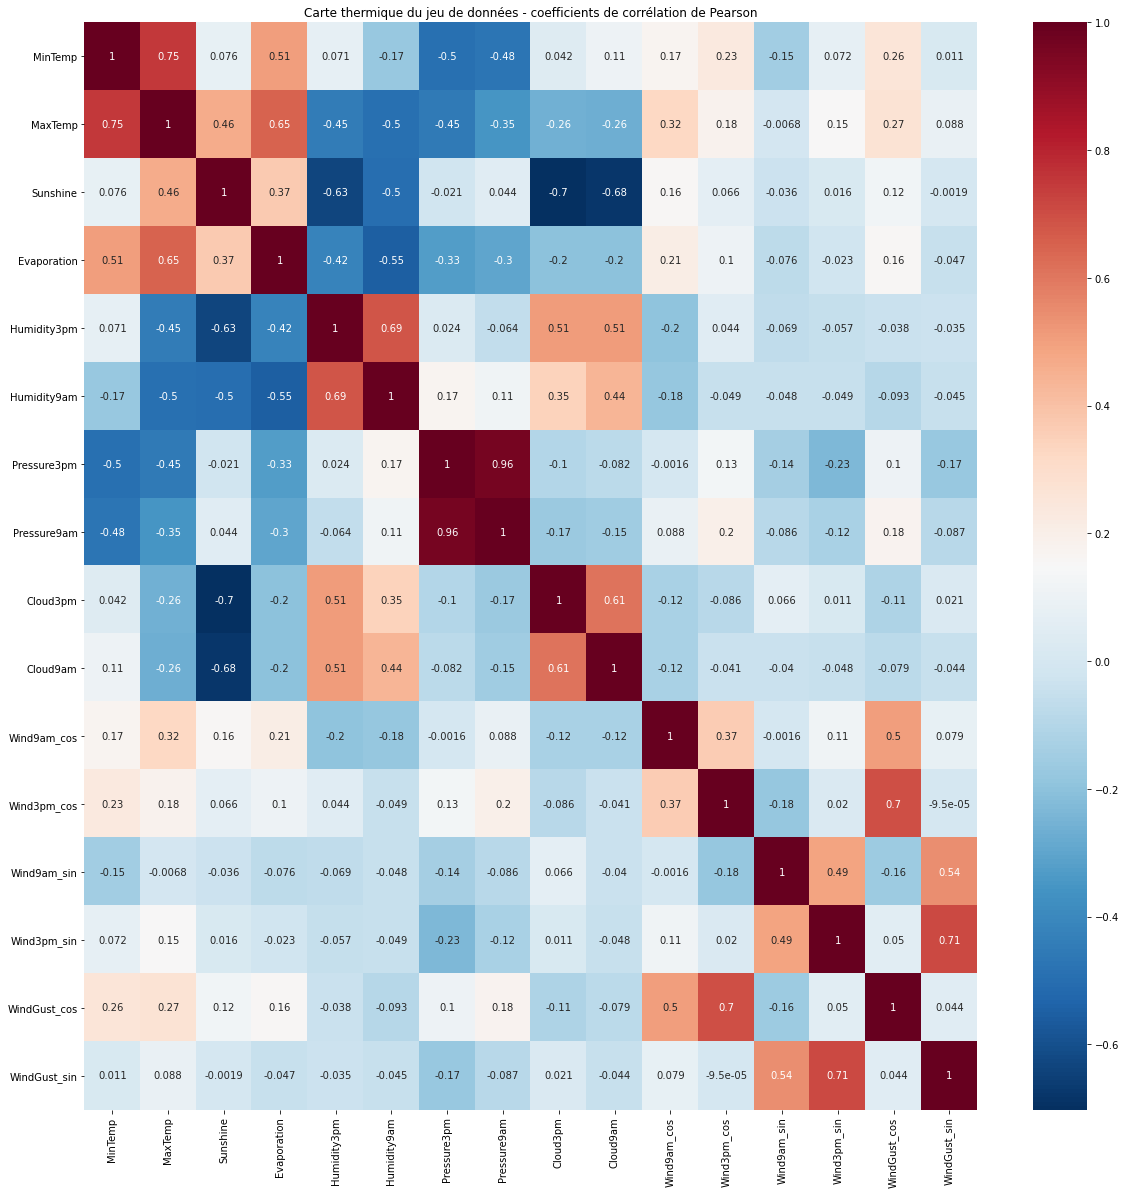

In [84]:
# Visualisation de la carte thermique du jeu de données
variables = ["MinTemp", "MaxTemp", "Sunshine", "Evaporation", "Humidity3pm", "Humidity9am", "Pressure3pm", "Pressure9am", 
            "Cloud3pm", "Cloud9am", "Wind9am_cos", "Wind3pm_cos", "Wind9am_sin", "Wind3pm_sin", 
             "WindGust_cos", "WindGust_sin"]
fig, ax = plt.subplots(figsize=(20,20))
cor = X_dropna[variables].corr()
sns.heatmap(cor, ax=ax, annot=True, cmap='RdBu_r')
plt.title("Carte thermique du jeu de données - coefficients de corrélation de Pearson");

Plusieurs variables du jeu de données sont des mesures de la même grandeur physique, à deux moments de la journée : 9h et 15h. Les deux variables présentent un coefficient de corrélation de Pearson supérieur à 0,6. Cette redondance de variables mesurant la même chose pourrait donner plus de poids à certaines grandeurs physiques dans l’entrainement du modèle et nuire aux performances.

Les variables concernées sont :
- MinTemp et MaxTemp (également corrélée avec Evaporation),
- Cloud9am et Cloud3pm,
- Humidity9am et Humidity3pm
- Pressure9am et Pressure3pm,
- Wind3pm_cos et WindGust_cos
- Wind3pm_sin et WindGust_sin

L’objectif est de tester les performances du modèle après avoir supprimé l’une des deux variables. Les scores présentés sont obtenus avec une RandomForest après rééquilibrage. 

In [97]:
X_train_red1 = X_ru_na.drop(['MaxTemp','Humidity9am', 'Pressure9am', 'Cloud9am', 'Wind3pm_cos', 'Wind3pm_sin'], axis=1)
X_test_red1 = X_test.drop(['MaxTemp','Humidity9am', 'Pressure9am', 'Cloud9am', 'Wind3pm_cos', 'Wind3pm_sin'], axis=1)

In [98]:
%%time
#entrainement dun modèle de RF sur le jeu de données réduit
rf_red1 = RandomForestClassifier()
rf_red1.fit(X_train_red1, y_ru_na)

#prédictions et évaluation
y_pred_rf_red1 = rf_red1.predict(X_test_red1)
print("performances sur test : \n", classification_report(y_test, y_pred_rf_red1))

performances sur test : 
               precision    recall  f1-score   support

           0       0.95      0.79      0.86     22746
           1       0.53      0.85      0.65      6345

    accuracy                           0.80     29091
   macro avg       0.74      0.82      0.76     29091
weighted avg       0.86      0.80      0.82     29091

Wall time: 3.86 s


Conclusion : Les scores des trois métriques sont proches voire identiques au jeu de données contenant toutes les variables. La suppression de variables corrélées entre elles ne permet donc pas d’améliorer les performances.

## 2e technique : Sélection de variables avec SelectKBest

L'objectif est de sélectionner les variables les plus corrélées à la cible en se basant sur un test du chi2 et de les intégrer une à une au modèle.

In [109]:
%%time
#SelectKBest nécessite des données positives pour le chi2
data_norm = MinMaxScaler().fit_transform(X_dropna)

#instanciation des listes des scores du modèle pour un nombre croissant de variables sélectionnées
f1 = []
rec = []
prec = []

#entrainement du modèle pour un nombre k croissant de variables sélectionnées et stockage des scores dans les listes
for i in range(len(X_dropna.columns)):
    
    #sélection des variables les plus corrélées à la cible selon le test du chi2
    selector = SelectKBest(chi2, k=i+1)
    selector.fit_transform(data_norm, y_dropna)
    select_bool = selector.get_support()

    #création de la liste des variables sélectionnées
    select_feats = []
    for feats, select in zip(X_dropna, select_bool):
        if select == True:
            select_feats.append(feats)
    
    #entrainement d'un algorithme de forêt aléatoire
    rf_rusel = RandomForestClassifier()
    rf_rusel.fit(X_ru_na[select_feats], y_ru_na)
        
    #prédictions
    y_pred_rf_rusel = rf_rusel.predict(X_test_na[select_feats])
    
    #mise à jour des listes des scores
    f1.append(f1_score(y_test_na, y_pred_rf_rusel))
    rec.append(recall_score(y_test_na, y_pred_rf_rusel))
    prec.append(precision_score(y_test_na, y_pred_rf_rusel))

Wall time: 1min 14s


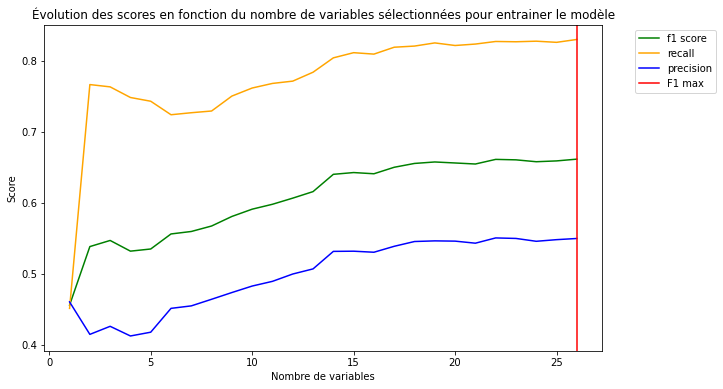

In [116]:
#Visualitation de l'évolution des scores en fonction du nombre de variables sélectionnées
x = np.arange(1, X_dropna.shape[1]+1)

plt.figure(figsize=(10,6))

plt.plot(x, f1, label='f1 score', color='green')
plt.plot(x, rec, label='recall', color='orange')
plt.plot(x, prec, label='precision', color='blue')

plt.title("Évolution des scores en fonction du nombre de variables sélectionnées pour entrainer le modèle")
plt.xlabel("Nombre de variables")
plt.ylabel("Score")

for score, k in zip(f1, x):
    if score == max(f1):
        maxvar = k

plt.axvline(x=maxvar, color='red', label="F1 max")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [121]:
#affichage du score f1 maximal
print("le F1-score maximum est égal à", round(f1[maxvar-1],2),
      ". Il est obtenu pour", maxvar, "variables sur", X_dropna.shape[1], ".")

le F1-score maximum est égal à 0.66 . Il est obtenu pour 26 variables sur 26 .


Conclusion : 
À partir de six variables, on observe une croissance de toutes les métriques au fur et à mesure qu’on intègre des variables. Il n'est donc pas nécessaire de supprimer des variables pour améliorer les scores. Toutefois, on remarque que les scores évoluent peu après 15 variables. La diminution du nombre de variables nous permettrait d'entrainer des modèles plus gourmands en ressource.

## Complément : Sélection de variables avec RFE

Nous testons l'algorithme RFE sur 16 variables (au-dela, les performances évoluent peu d'après les résultats de SelectKBest).

In [125]:
%%time
#instanciation dune RandomForest et d'un RFE
rf = RandomForestClassifier()
rfe = RFE(estimator=rf, step=1, n_features_to_select=16)

#sélection des variables par rfe
rfe.fit(X_ru_na, y_ru_na)
X_ru_sel = rfe.transform(X_ru_na)
X_test_sel = rfe.transform(X_test_na)

#entrainement, prédictions et évaluation de la Random Forest
rf.fit(X_ru_sel, y_ru_na)
y_pred = rf.predict(X_test_sel)
print("performances sur test : \n", classification_report_imbalanced(y_test_na, y_pred))

performances sur test : 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.81      0.82      0.87      0.81      0.66      8837
          1       0.54      0.82      0.81      0.65      0.81      0.66      2476

avg / total       0.85      0.81      0.82      0.82      0.81      0.66     11313

Wall time: 44.7 s


Conclusion : La réduction du nombre de variables ne permet pas d'améliorer les performances.

# Conclusion du Notebook

Les différents tests menés sur le jeu de données nous amènent aux conclusions suivantes :
- Le rééchantillonnage permet d'obtenir des scores légèrement meilleurs, mais c'est surtout le choix du seuil de décision qui a le plus d'impact sur les performances.
- L'interpolation des valeurs manquantes par KNN Imputer réduit les performances au lieu de les améliorer.
- Le retrait de certaines variables n'améliore pas les performances.